In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from utils.prompt_utils import load_dataset, generate_prompt_with_corrupted_instruction
from utils.model_utils import load_gpt_model_and_tokenizer
from utils.extract_utils import get_mean_head_activations, get_mean_layer_activations
from utils.eval_utils import n_shot_eval_no_intervention
from compute_indirect_effect import compute_indirect_effect
import torch
import importlib

torch.set_grad_enabled(False)

In [3]:
model, tokenizer, model_config = load_gpt_model_and_tokenizer("../flan-llama-7b/", device="cuda")

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading:  ../flan-llama-7b/


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset = load_dataset("antonym")

In [8]:
prefixes = {"input": "Input:", "output": "Output:", "instructions": "Instruction: Output the antonym of the given word."}
separators = {"input":"\n", "output":"\n", "instructions":"\n"}

In [9]:
activations = get_mean_head_activations(dataset=dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=0, N_TRIALS=1, prefixes=prefixes, separators=separators)

In [76]:
cie = compute_indirect_effect(dataset=dataset, model=model, model_config=model_config, mean_activations=activations, tokenizer=tokenizer, n_shots=0, n_trials=25, prefixes=prefixes, separators=separators, instruction_ablation="mean")

  0%|          | 0/25 [00:00<?, ?it/s]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

  4%|▍         | 1/25 [00:34<13:45, 34.39s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

  8%|▊         | 2/25 [01:09<13:15, 34.59s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 12%|█▏        | 3/25 [01:43<12:40, 34.58s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 16%|█▌        | 4/25 [02:17<11:57, 34.17s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 20%|██        | 5/25 [02:50<11:18, 33.91s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 24%|██▍       | 6/25 [03:24<10:44, 33.92s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 28%|██▊       | 7/25 [03:58<10:12, 34.02s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 32%|███▏      | 8/25 [04:33<09:39, 34.06s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 36%|███▌      | 9/25 [05:07<09:05, 34.08s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 40%|████      | 10/25 [05:40<08:29, 33.98s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 44%|████▍     | 11/25 [06:15<07:58, 34.19s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 48%|████▊     | 12/25 [06:49<07:24, 34.21s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 52%|█████▏    | 13/25 [07:24<06:51, 34.33s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 56%|█████▌    | 14/25 [07:59<06:18, 34.43s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 60%|██████    | 15/25 [08:33<05:45, 34.55s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 64%|██████▍   | 16/25 [09:08<05:11, 34.59s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 68%|██████▊   | 17/25 [09:43<04:37, 34.63s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 72%|███████▏  | 18/25 [10:18<04:02, 34.65s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 76%|███████▌  | 19/25 [10:52<03:27, 34.66s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 80%|████████  | 20/25 [11:26<02:52, 34.52s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 84%|████████▍ | 21/25 [12:00<02:17, 34.36s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 88%|████████▊ | 22/25 [12:35<01:43, 34.42s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 92%|█████████▏| 23/25 [13:10<01:09, 34.52s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

 96%|█████████▌| 24/25 [13:44<00:34, 34.56s/it]

tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
       device='cuda:0', dtype=torch.float16)
tensor([[-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062]],
 

100%|██████████| 25/25 [14:18<00:00, 34.35s/it]


In [77]:
avg_cie = torch.mean(cie, axis=0)

In [14]:
avg_cie = torch.mean(cie, axis=0)

In [78]:
avg_cie = np.array(avg_cie)
avg_cie = avg_cie.squeeze()

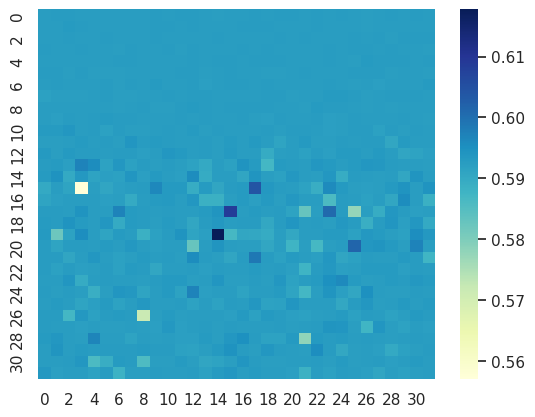

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.heatmap(avg_cie, cmap="YlGnBu")
plt.show()

In [29]:
icl_model_icl_cie = torch.load("../cie/antonym/antonym_indirect_effect.pt")
flan_model_icl_cie = torch.load("../flan-cie/antonym/antonym_indirect_effect.pt")

In [30]:
icl_model_icl_cie = torch.mean(icl_model_icl_cie, axis=0)
flan_model_icl_cie = torch.mean(flan_model_icl_cie, axis=0)

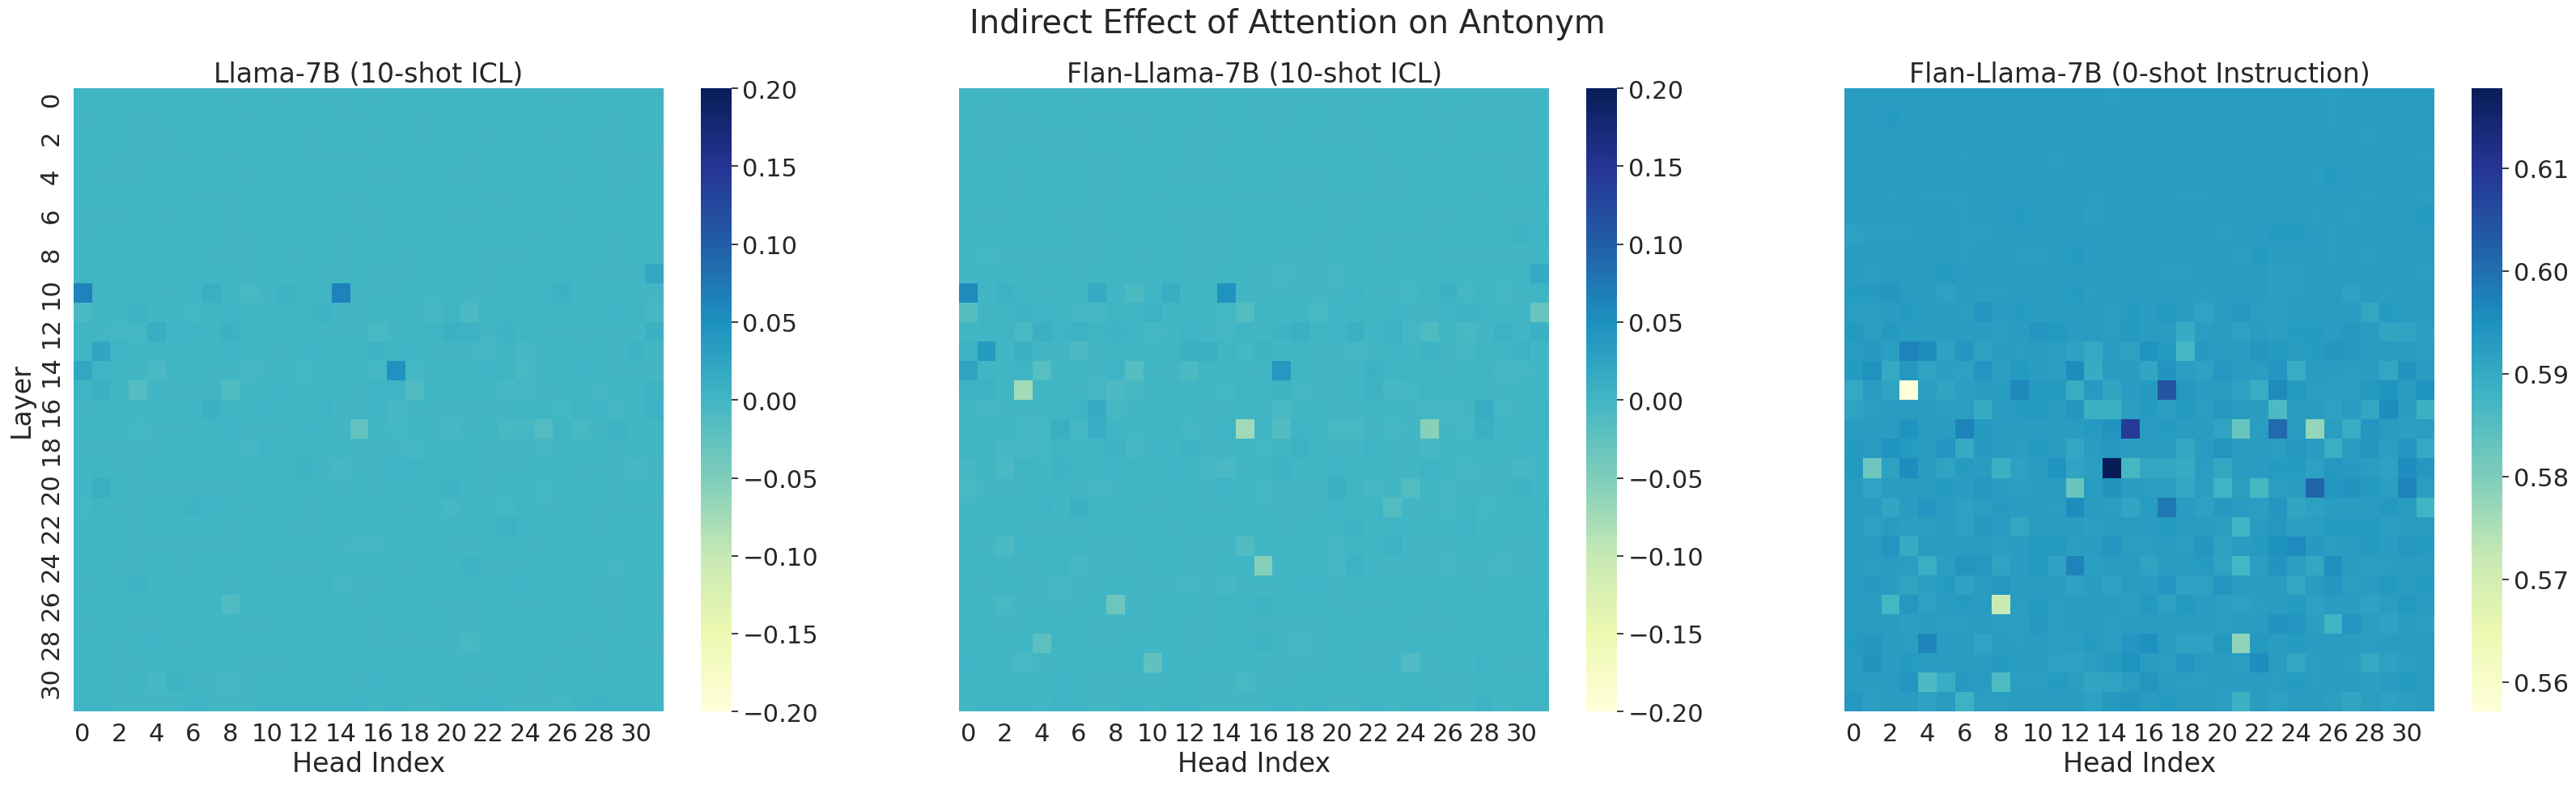

In [85]:
sns.set(font_scale=2)
fig, axes = plt.subplots(1, 3, figsize=(40, 10), sharey=True)

sns.heatmap(icl_model_icl_cie, cmap="YlGnBu", ax=axes[0], vmin=-0.2, vmax=0.2)
axes[0].set_title("Llama-7B (10-shot ICL)")
axes[0].set_ylabel("Layer")
axes[0].set_xlabel("Head Index")


sns.heatmap(flan_model_icl_cie, cmap="YlGnBu", ax=axes[1], vmin=-0.2, vmax=0.2)
axes[1].set_title("Flan-Llama-7B (10-shot ICL)")
axes[1].set_xlabel("Head Index")

sns.heatmap(avg_cie, cmap="YlGnBu", ax=axes[2])
axes[2].set_title("Flan-Llama-7B (0-shot Instruction)")
axes[2].set_xlabel("Head Index")

fig.suptitle("Indirect Effect of Attention on Antonym")
plt.show()


In [44]:
fig.savefig("antonym_indirect_effect.pdf", bbox_inches='tight')

In [45]:
unk_cie = compute_indirect_effect(dataset=dataset, model=model, model_config=model_config, mean_activations=activations, tokenizer=tokenizer, n_shots=0, n_trials=1, prefixes=prefixes, separators=separators, instruction_ablation="unknown")

100%|██████████| 1/1 [00:33<00:00, 33.65s/it]


In [48]:
unk_cie = torch.squeeze(unk_cie)
unk_cie = np.array(unk_cie)

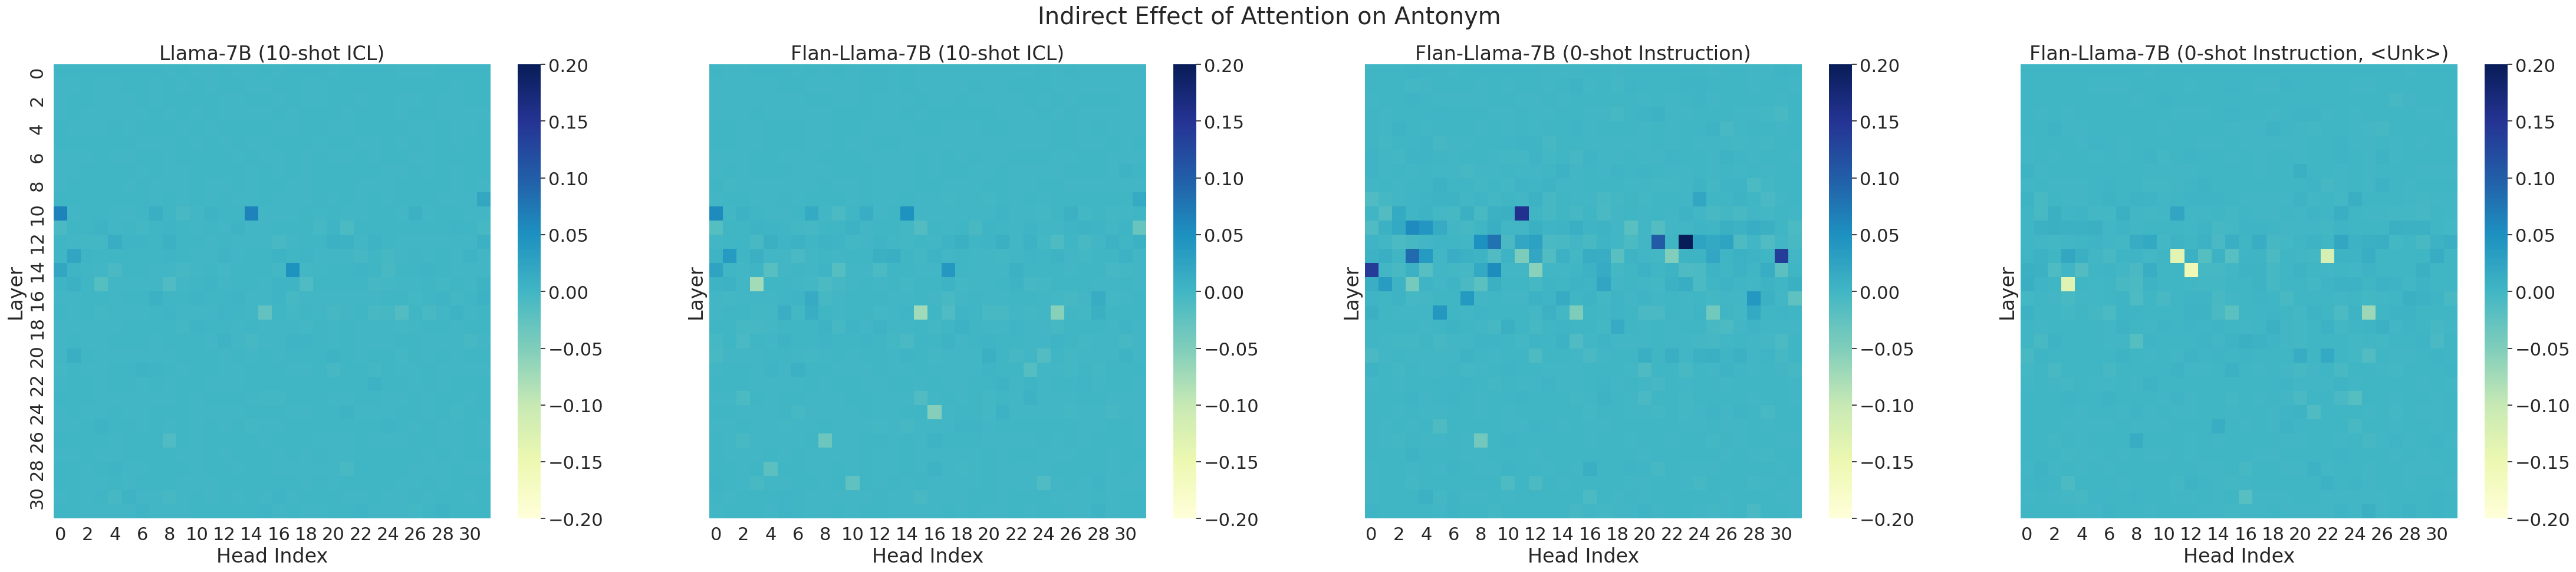

In [49]:
sns.set(font_scale=2)
fig, axes = plt.subplots(1, 4, figsize=(55, 10), sharey=True)

sns.heatmap(icl_model_icl_cie, cmap="YlGnBu", ax=axes[0], vmin=-0.2, vmax=0.2)
axes[0].set_title("Llama-7B (10-shot ICL)")
axes[0].set_ylabel("Layer")
axes[0].set_xlabel("Head Index")


sns.heatmap(flan_model_icl_cie, cmap="YlGnBu", ax=axes[1], vmin=-0.2, vmax=0.2)
axes[1].set_title("Flan-Llama-7B (10-shot ICL)")
axes[1].set_ylabel("Layer")
axes[1].set_xlabel("Head Index")

sns.heatmap(avg_cie, cmap="YlGnBu", ax=axes[2], vmin=-0.2, vmax=0.2)
axes[2].set_title("Flan-Llama-7B (0-shot Instruction)")
axes[2].set_ylabel("Layer")
axes[2].set_xlabel("Head Index")

sns.heatmap(unk_cie, cmap="YlGnBu", ax=axes[3], vmin=-0.2, vmax=0.2)
axes[3].set_title("Flan-Llama-7B (0-shot Instruction, <Unk>)")
axes[3].set_ylabel("Layer")
axes[3].set_xlabel("Head Index")

fig.suptitle("Indirect Effect of Attention on Antonym")
plt.show()


In [66]:
input_text = "Instruction: Output the antonym of the given word.\nInput: search\nOutput: "
inputs = tokenizer(input_text, return_tensors="pt")
inputs = {k: v.to("cuda") for k, v in inputs.items()}

In [61]:
mean_noise = torch.mean(model.model.embed_tokens.weight, dim=0)

In [63]:
mean_noise

tensor([-0.0031, -0.0005,  0.0017,  ...,  0.0043, -0.0013, -0.0062],
       device='cuda:0', dtype=torch.float16)

In [69]:
emb = model.model.embed_tokens(inputs["input_ids"])

In [68]:
inputs

{'input_ids': tensor([[    1,  2799,  4080, 29901, 10604,   278,   385,   880,   962,   310,
            278,  2183,  1734, 29889,    13,  4290, 29901,  2740,    13,  6466,
          29901, 29871]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [70]:
emb.shape

torch.Size([1, 22, 4096])

In [2]:
import torch
v = torch.load("../ins-mean/antonym/antonym_indirect_effect.pt")

In [4]:
v

tensor([[[ 2.2210e-10,  2.4162e-10,  5.1653e-10,  ...,  5.9237e-10,
           9.9836e-10, -1.6893e-10],
         [-1.9724e-10,  9.4543e-11, -2.9096e-10,  ...,  1.1152e-09,
           8.8941e-10,  5.0378e-10],
         [ 6.8928e-10, -1.9061e-10,  2.4502e-10,  ...,  1.0353e-10,
           1.9327e-10, -3.4436e-11],
         ...,
         [-1.2610e-09, -1.4679e-10,  2.4132e-11,  ..., -1.2552e-09,
           9.3173e-10,  3.2180e-10],
         [-4.4754e-10, -3.9573e-10,  1.0110e-09,  ..., -4.9416e-10,
           1.8598e-10, -1.6911e-11],
         [ 7.9524e-11, -1.5047e-09,  3.7166e-10,  ...,  5.8786e-10,
           1.1150e-09,  2.7971e-11]],

        [[-1.4738e-05, -1.7624e-05,  1.6409e-05,  ...,  7.3932e-06,
           7.3633e-06, -8.8733e-06],
         [-1.5685e-06, -1.0453e-05, -1.5146e-06,  ..., -2.0366e-05,
           1.4994e-05,  2.9000e-05],
         [-6.0539e-06, -5.9397e-06, -8.8472e-06,  ..., -1.0264e-05,
          -1.1852e-05, -1.3643e-05],
         ...,
         [-1.6008e-06, -1